## Modeling with logistic regression

In [46]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.compose import  ColumnTransformer, make_column_transformer

from nltk.corpus import stopwords 
from bs4 import BeautifulSoup
import string
import regex as re

In [38]:
%store -r combined
%store -r ripple_df

In [39]:
combined.head(2)

,title,selftext,subreddit,title_selftext
0,🏦Remitano is Rewarding Every Delayed Transacti...,"Starting from ⏱February 10, 2020, Remitano wil...",1,🏦Remitano is Rewarding Every Delayed Transacti...
1,Veteran Trader: Bitcoin Should be Viewed as “C...,[removed],1,Veteran Trader: Bitcoin Should be Viewed as “C...


In [43]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    stops.update(list(string.punctuation))
#     words_add = ['removed', 'http', 'startup', 'startups', 'streaming']
#     stops.update(list(words_add))

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [47]:
combined['cleaned'] = combined.title_selftext.map(review_to_words)

In [48]:
combined.head(2)

,title,selftext,subreddit,title_selftext,cleaned
0,🏦Remitano is Rewarding Every Delayed Transacti...,"Starting from ⏱February 10, 2020, Remitano wil...",1,🏦Remitano is Rewarding Every Delayed Transacti...,remitano rewarding every delayed transactional...
1,Veteran Trader: Bitcoin Should be Viewed as “C...,[removed],1,Veteran Trader: Bitcoin Should be Viewed as “C...,veteran trader bitcoin viewed catastrophic ins...


In [49]:
#baseline model
combined['subreddit'].value_counts(normalize = True)

1    0.624503
0    0.375497
Name: subreddit, dtype: float64

In [51]:
#set X and y variables
X = combined[['cleaned']]
y = combined['subreddit']

### Train/test/split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   stratify = y, random_state = 42)

In [53]:
y_test.value_counts(normalize = True)

1    0.623841
0    0.376159
Name: subreddit, dtype: float64

**lemmatokenizer**

In [54]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [57]:
col_transformer_cv = make_column_transformer(
  (CountVectorizer(tokenizer = LemmaTokenizer()), 'cleaned'),
  remainder = 'passthrough'
)
col_transformer_td = make_column_transformer(
  (TfidfVectorizer(tokenizer = LemmaTokenizer()), 'cleaned'),
  remainder = 'passthrough'
)
pipe_lr_cv = Pipeline([
    ("col_trans", col_transformer_cv),
    ("log_reg", LogisticRegression(solver = "liblinear"))])

pipe_lr_td = Pipeline([
    ("col_trans", col_transformer_td),
    ("log_reg", LogisticRegression(solver = "liblinear"))])
    
# Construct Grid Parameters for CountVectorizer
hyperparams_cv = {
               'col_trans__countvectorizer__ngram_range': [(1,1), (1,2)],
               'col_trans__countvectorizer__stop_words': [None,'english'],
               'col_trans__countvectorizer__max_features': [None, 100, 500,1000],
               'col_trans__countvectorizer__min_df': [1, 3, 4],
               'col_trans__countvectorizer__max_df': [0.9, 0.95, .9],
#                 'logreg__C': [1, 5, 100],
#                 'logreg__penalty' : ['l1','l2']
                 }
# Construct Grid Parameters for TDIDFFVectorizer
hyperparams_td = {'col_trans__tfidfvectorizer__ngram_range': [(1,1), (1,2)],
               'col_trans__tfidfvectorizer__stop_words': [None, 'english'],
               'col_trans__tfidfvectorizer__max_features': [None, 100, 500,1000],
               'col_trans__tfidfvectorizer__min_df': [1, 3, 4],
               'col_trans__tfidfvectorizer__max_df': [0.9, 0.95, .99]
                 }

**Logisticregression & countvectorizer**

In [58]:
gs_lr_cv = GridSearchCV(pipe_lr_cv, param_grid=hyperparams_cv, verbose=1,cv=5,n_jobs=4)
gs_lr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/kalz/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  3.3min finished
/Users/kalz/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('col_trans',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('countvectorizer',
                                                                         CountVectorizer(analyzer='word',
                                                                                         binary=False,
                                                                                         decode_error='strict',
                                                                                         dtype=<class 'numpy.int64'>,
                 

In [59]:
print(f'Train score: {gs_lr_cv.score(X_train, y_train)}')
print(f'Test score: {gs_lr_cv.score(X_test, y_test)}')

Train score: 0.9951434878587196
Test score: 0.8913907284768212


In [60]:
#best parameters
gs_lr_cv.best_params_

{'col_trans__countvectorizer__max_df': 0.9,
 'col_trans__countvectorizer__max_features': None,
 'col_trans__countvectorizer__min_df': 1,
 'col_trans__countvectorizer__ngram_range': (1, 2),
 'col_trans__countvectorizer__stop_words': 'english'}

In [61]:
#confusion Matrix
pred_y_cv = gs_lr_cv.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, pred_y_cv), 
             columns=['predict_bitcoin', 'predict_ethereum'], 
             index=['actual_bitcoin', 'actual_ethereum'])

,predict_bitcoin,predict_ethereum
actual_bitcoin,254,30
actual_ethereum,52,419


In [84]:
df = pd.DataFrame(pipe_lr_cv['col_trans'].fit_transform(X_test).toarray(), columns =
             pipe_lr_cv['col_trans'].get_feature_names())

In [85]:
df['predictions'] = gs_lr_cv.predict(X_test)

In [86]:
df.loc[df['predictions'] == 0].sum().sort_values(ascending=False)

countvectorizer__removed        228
countvectorizer__ethereum       135
countvectorizer__transaction    124
countvectorizer__http           107
countvectorizer__channel         86
                               ... 
countvectorizer__mcfadyen         0
countvectorizer__mcfadyed         0
countvectorizer__matyuyt          0
countvectorizer__mature           0
countvectorizer__aa               0
Length: 5331, dtype: int64

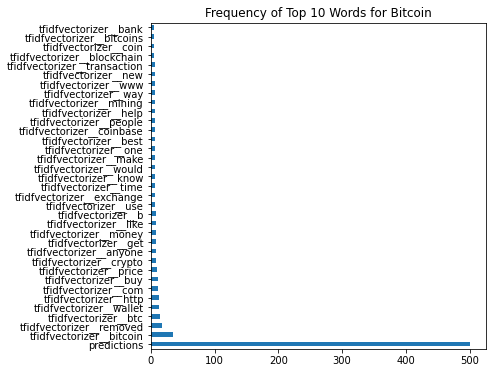

In [107]:
plt.figure(figsize = (6,6))
df.loc[df['predictions'] == 1].sum().sort_values(ascending=False).head(35).plot(kind='barh')
plt.title('Frequency of Top 10 Words for Bitcoin')
plt.ylabel("")
plt.show()

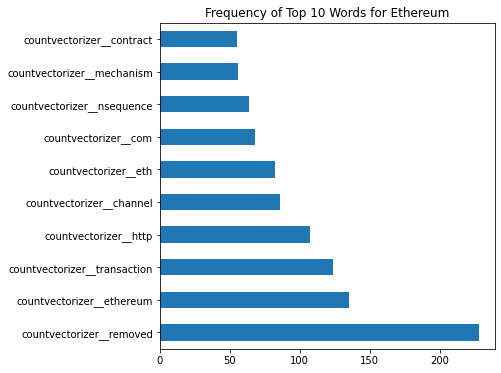

In [88]:
plt.figure(figsize = (6,6))
df.loc[df['predictions'] == 0].sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Frequency of Top 10 Words for Ethereum')
plt.ylabel("")
plt.show()

**Logisitic regression & TFIDFVectorizer**

In [95]:
gs_lr_td = GridSearchCV(pipe_lr_td, param_grid=hyperparams_td, verbose=1,cv=5,n_jobs=4)
gs_lr_td.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('col_trans',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(analyzer='word',
                                                                                         binary=False,
                                                                                         decode_error='strict',
                                                                                         dtype=<class 'numpy.float64'>,
               

In [96]:
df = pd.DataFrame(pipe_lr_td['col_trans'].fit_transform(X_test).toarray(), columns =
             pipe_lr_td['col_trans'].get_feature_names())

In [97]:
df['predictions'] = gs_lr_td.predict(X_test)

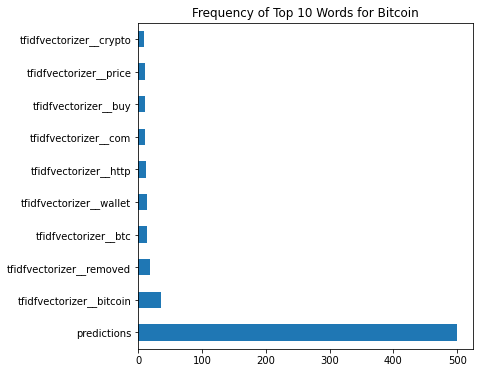

In [100]:
plt.figure(figsize = (6,6))
df.loc[df['predictions'] == 1].sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Frequency of Top 10 Words for Bitcoin')
plt.ylabel("")
plt.show()

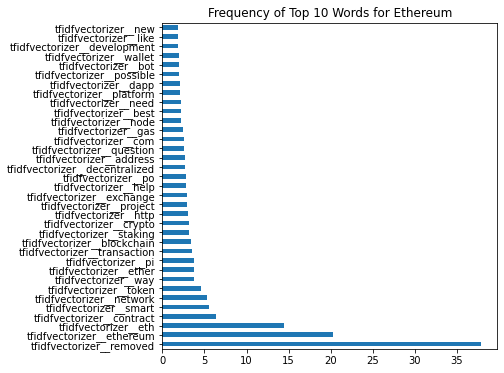

In [108]:
plt.figure(figsize = (6,6))
df.loc[df['predictions'] == 0].sum().sort_values(ascending=False).head(35).plot(kind='barh')
plt.title('Frequency of Top 10 Words for Ethereum')
plt.ylabel("")
plt.show()

In [102]:
print(f'Train score: {gs_lr_td.score(X_train, y_train)}')
print(f'Test score: {gs_lr_td.score(X_test, y_test)}')

Train score: 0.9258278145695364
Test score: 0.8688741721854305


In [103]:
#best parameters
gs_lr_td.best_params_

{'col_trans__tfidfvectorizer__max_df': 0.9,
 'col_trans__tfidfvectorizer__max_features': 1000,
 'col_trans__tfidfvectorizer__min_df': 1,
 'col_trans__tfidfvectorizer__ngram_range': (1, 1),
 'col_trans__tfidfvectorizer__stop_words': None}

In [104]:
#confusion Matrix
pred_y_td = gs_lr_td.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, pred_y_td), 
             columns=['predict_bitcoin', 'predict_ethereum'], 
             index=['actual_bitcoin', 'actual_ethereum'])

,predict_bitcoin,predict_ethereum
actual_bitcoin,220,64
actual_ethereum,35,436


## Summary of logistic regression

**Hyperparameters**

|  	|TFIDFVectorizer  	|CountVectorizer  	|
|---	|---	|---	|
|max_df  	|0.9  	|0.9  	|
|min_df  	|1000  	|1  	|
|max_features  	|None  	|None  	|
|ngram_range  	|(1, 1)  	|(1, 2)  	|
|stop_words  	|None  	|english  	|

**Accuracy score**

|  	|TFIDFVectorizer  	|CountVectorizer  	|
|---	|---	|---	|
|Train   	|0.926  	|0.995  	|
|Test  	|0.869  	|0.891  	|

**Confusion Matrix**

 - **TFIDFVectorizer**

|  	|predict_bitcoin  	|predict_ethereum  	|
|---	|---	|---	|
|actual_bitcoin  	|220  	|64  	|
|actual_ethereum	  	|35  	|436 	|

- **CountVectorizer**

|  	|predict_bitcoin  	|predict_ethereum  	|
|---	|---	|---	|
|actual_bitcoin  	|254  	|30  	|
|actual_ethereum	  	|52  	|419  	|

In [19]:
%store X_train
%store ripple_df

Stored 'X_train' (DataFrame)
Stored 'ripple_df' (DataFrame)


In [105]:
%store X
%store y

Stored 'X' (DataFrame)
Stored 'y' (Series)
